## Calculating Beta (along with some other values)

I had some difficulty finding an easy way to calculate Beta values. Given that we need to have low volatility to enter our algorithms into Quantopian's competition, this should be (at least somewhat) helpful to everybody. 

There is a really good statistical evaluator in the 'Quantopian Lecture Series: Linear Regression'. It looks like this:

In [11]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

In [12]:
# Define the actual linear regression function
def linreg(X,Y):
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     62.36
Date:                Thu, 20 Apr 2017   Prob (F-statistic):           9.14e-14
Time:                        05:03:01   Log-Likelihood:                 548.44
No. Observations:                 251   AIC:                            -1093.
Df Residuals:                     249   BIC:                            -1086.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0009      0.002      0.539      0.590        -0.002     0.004
x1             1.9253      0.244      7.897      0.000         1.445     2.406
==============================================================================
Omnibus:                       64.190   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.908
Skew:                           0.857   Prob(JB):                     7.81e-81
Kurtosis:                       8.686   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

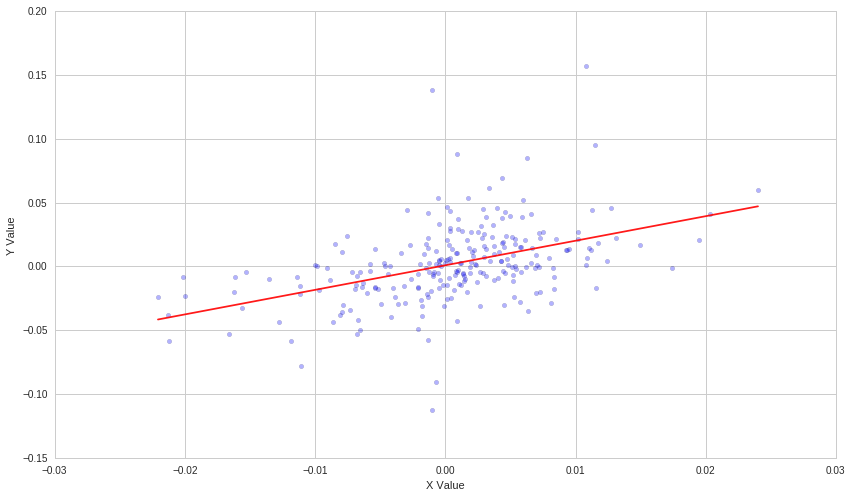

In [13]:
# Get our pricing data
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('TSLA', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('SPY', fields='price', start_date=start, end_date=end)

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

linreg(r_b.values, r_a.values)

The important numbers here are 9.14e-14 from Prob (F-statistic) and 1.9253 from x1 coef. We want the first number to be very low, at minimum less than .05, so we know there's a statistical significance. If the p value is not less than .05, it's certain that you're looking at things that are just not likely to be predictive in any way, so you should stop pursuing what ever strategy you were doing. The second number is the Beta, how correlated our asset is compared to the benchmark. In this case, TSLA is twice as volatile as SPY. This could be good or bad depending on your strategy. Either way, it's good to know that you can access it easily. 

A possible issue with the method above however is that you probably don't need all that information plus the pretty graph. The number you're most likely going to need over and over again is Beta so here's a function that will get you just the Beta value. (This one is very similiar to a method from 'Quantopian Lecture Series: The Art of Not Following the Market'. I just changed it so it returns beta since you'll (probably) be more interested with Beta than Alpha here.)

In [14]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linregbeta(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[1]  # , model.params[0]  <-- include this if you also want alpha

beta = linregbeta(X,Y)
print 'beta: ' + str(beta)

beta: 1.92533467685


Notice that the value are the same as before, so this function works.

Of course, this will also work with a list of tickers so you can evaluate a bunch of stocks very quickly. Here's an example.

In [ ]:
# Same idea, but this time we'll show that the function works with a list of companies
# SPY data stays the same so we won't touch that here

companies = ['TSLA', 'GE', 'TOT', 'MSFT', 'C']
assets = get_pricing(companies, fields='price', start_date=start, end_date=end)

# Change to % change
assets_pct_chng = assets.pct_change()[1:]

# Let's define everything in familiar regression terms
Y = assets_pct_chng.values # Get just the values, ignore the timestamps

beta = linregbeta(X,Y)
print 'beta: ' + str(beta)

beta: [ 1.92533468  0.9879742   1.25462463  0.9599409   1.26415886]


Wow, that was easy. Hopefully you guys will find this useful in minimizing Beta in future applications.